<a href="https://colab.research.google.com/github/Afqufai/MachineLearning2025_03/blob/main/TI_3G_03_Afrizal_Qurratul_Faizin_UTS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# UTS Machine Learning — Heart Disease Dataset
Untuk mahasiswa dengan nomor absen 3, 6, 10, dst.

Deskripsi: Dataset medis untuk melihat pengelompokan pasien berdasarkan fitur
kesehatan seperti tekanan darah, kolesterol, umur, dan lain-lain.

**Langkah tambahan:**
- Tangani nilai kosong (jika ada).
- Buat fitur gabungan seperti “CholAge = cholesterol × age”.

- - -

**Output yang Diharapkan**

Untuk setiap studi kasus, laporan dan notebook Colab harus memuat:
1. Penjelasan singkat dataset (jumlah sampel, fitur, tipe data).
2. Proses preprocessing (missing values, normalisasi, pembuatan fitur baru).
3. Hasil clustering KMeans dan DBSCAN, lengkap dengan:
    - Nilai Silhouette dan Davies–Bouldin
    - Visualisasi 2D (PCA/TSNE opsional)
4. Implementasi Annoy:
    - Pemilihan 3–5 titik query secara acak
    - Output index dan tetangga terdekat dengan nilai jaraknya

- - -

## Preparation

In [26]:
# Import all the stuff.
!pip install annoy
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Dataset/heart.csv')
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [28]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [29]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## Pre-processing

In [30]:
# Cari null
df.isnull().sum()
# Catatan setelah pengecekan: Dataset tidak punya null.

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [31]:
# Buat fitur baru
# Contoh: - Buat fitur gabungan seperti “CholAge = cholesterol × age”.
df['CholAge'] = df['chol'] * df['age']

# Rasio: Seberapa 'fit' jantung pasien
df['hr_achieved_ratio'] = df['thalach'] / (220 - df['age'] + 1e-6)

# Skor Resiko
# High_CHol kalau Kolesterol > 240
df['High_Chol'] = (df['chol'] > 240).astype(int)
# High_BP kalau Blood Pressure > 140
df['High_BP'] = (df['trestbps'] > 140).astype(int)
# Jumlahkan hasil High_Col, High_BP, fbs, dan exang
df['Risk_Score'] = df['High_Chol'] + df['High_BP'] + df['fbs'] + df['exang']

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,CholAge,hr_achieved_ratio,High_Chol,High_BP,Risk_Score
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,11024,1.000000,0,0,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,10759,0.928144,0,0,2
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,12180,0.833333,0,1,2
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,12383,1.012579,0,1,1
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,18228,0.670886,1,0,2


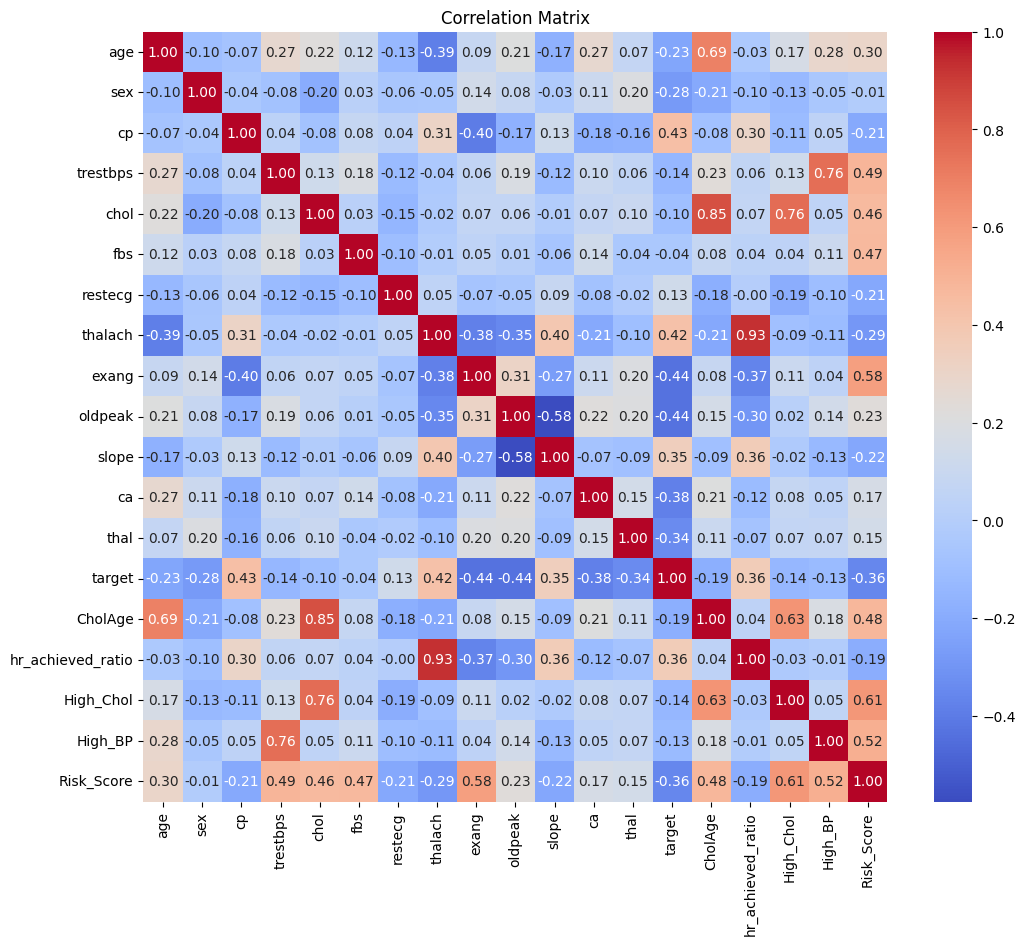

In [32]:
# Cari korelasi
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

In [33]:
# Pisahkan Fitur Numerik vs Kategorikal
numeric_features = ['thalach', 'oldpeak', 'CholAge', 'Risk_Score']
categorical_features = ['cp', 'exang', 'slope', 'ca', 'thal']

# Pisahkan dataframe
X_numeric = df[numeric_features]
X_categorical = df[categorical_features]

# One-hot encoding
X_categorical_encoded = pd.get_dummies(X_categorical.astype(str), drop_first=True)

print(f"Bentuk data kategorikal setelah di-encode: {X_categorical_encoded.shape}")

# Gabungkan fitur numerik ASLI dengan fitur kategorikal yg SUDAH di-encode
X_final = pd.concat([X_numeric, X_categorical_encoded], axis=1)

print(f"Bentuk data final sebelum di-scale: {X_final.shape}")

Bentuk data kategorikal setelah di-encode: (1025, 13)
Bentuk data final sebelum di-scale: (1025, 17)


In [34]:
# Scale karena semua angka
scaler = StandardScaler()
X_final_scaled = scaler.fit_transform(X_final)

# Display the first few rows of the CORRECTLY scaled data
print("\nData yang SUDAH BENAR di-scaling (first 5 rows):")
print(X_final_scaled[:5])


Data yang SUDAH BENAR di-scaling (first 5 rows):
[[ 0.82132052 -0.06088839 -0.61501401 -1.23910448 -0.44117876 -0.61908469
  -0.28499759 -0.71228712 -0.94215771  1.08880718 -0.53183979  2.57861469
  -0.26865542 -0.13369696 -0.25806452 -1.06347409  1.22474487]
 [ 0.2559679   1.72713707 -0.68100825  0.8464162  -0.44117876 -0.61908469
  -0.28499759  1.40392824 -0.94215771 -0.91843627 -0.53183979 -0.38780513
  -0.26865542 -0.13369696 -0.25806452 -1.06347409  1.22474487]
 [-1.04869198  1.30141672 -0.32712974  0.8464162  -0.44117876 -0.61908469
  -0.28499759  1.40392824 -0.94215771 -0.91843627 -0.53183979 -0.38780513
  -0.26865542 -0.13369696 -0.25806452 -1.06347409  1.22474487]
 [ 0.51689988 -0.91232909 -0.27657566 -0.19634414 -0.44117876 -0.61908469
  -0.28499759 -0.71228712 -0.94215771  1.08880718  1.88026547 -0.38780513
  -0.26865542 -0.13369696 -0.25806452 -1.06347409  1.22474487]
 [-1.87497657  0.70540823  1.17903298  0.8464162  -0.44117876 -0.61908469
  -0.28499759 -0.71228712  1.061

## K-Means
Cari cluster pakai Metode ELBOW.

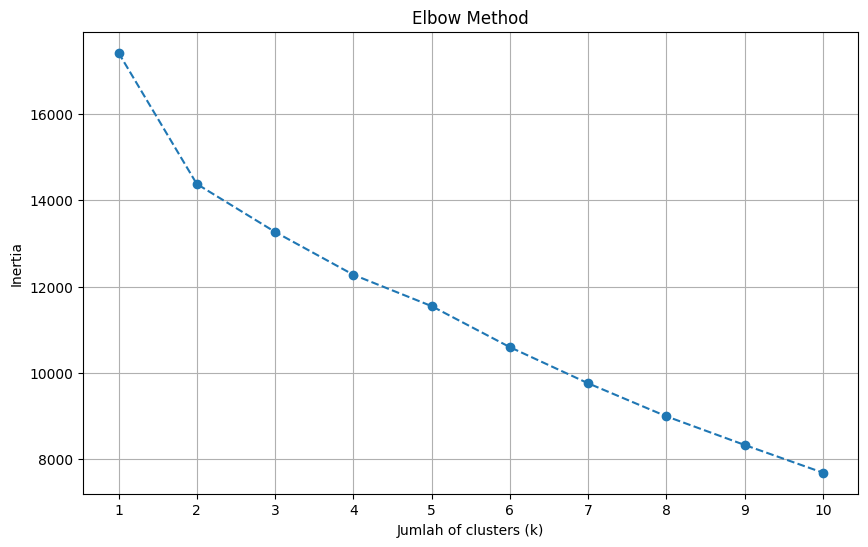

In [35]:
#   E   L   B   O   W
wcss = []
k_range = range(1, 11)

for k in k_range:
  # Buat model, terus latih
  kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
  kmeans_model.fit(X_final_scaled)
  wcss.append(kmeans_model.inertia_) # Inertia masuk ke arraynya

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Jumlah of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Hasil elbow menunjukkan di **k=2**

Silhouette Score (KMeans): 0.1836
Davies-Bouldin Index (KMeans): 2.0781


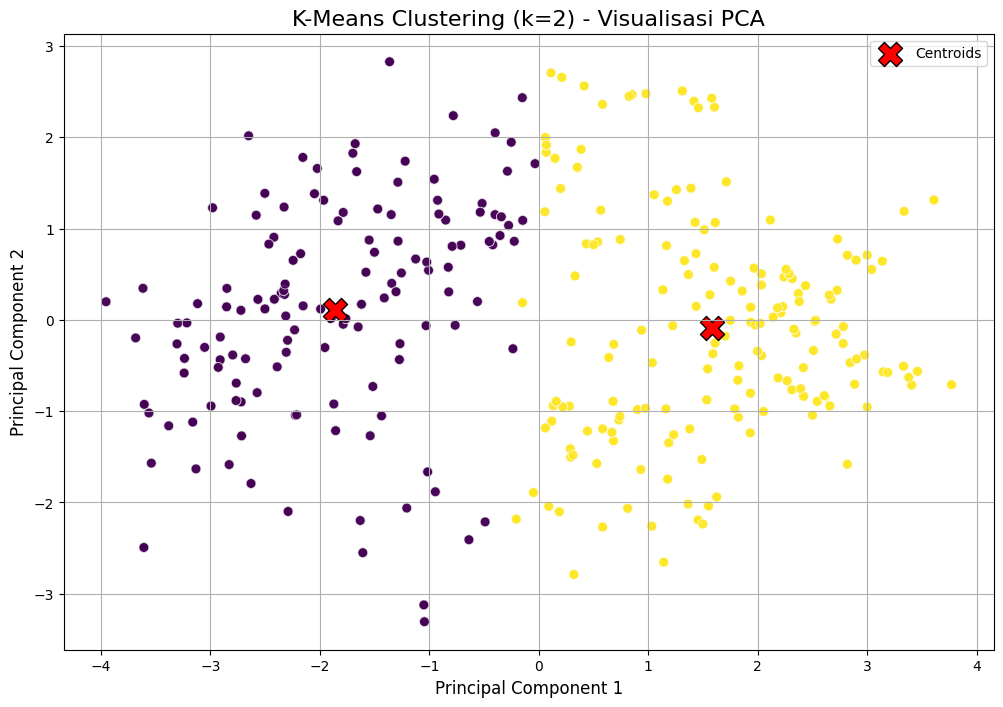

In [36]:
# Pakai hasil elbow method
kmeans_model = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=42)
kmeans_labels = kmeans_model.fit_predict(X_final_scaled)

# Cari skor Silhouette dan Davies-Bouldin
silhouette_avg = silhouette_score(X_final_scaled, kmeans_labels)
davies_bouldin_avg = davies_bouldin_score(X_final_scaled, kmeans_labels)

print(f"Silhouette Score (KMeans): {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index (KMeans): {davies_bouldin_avg:.4f}")

# Visualize
# Make it 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_final_scaled)

# 2D Centroid
centroids_original_space = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids_original_space)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)
# Plot PUSAT CLUSTER (Centroids)
plt.scatter(x=centroids_pca[:, 0], y=centroids_pca[:, 1],
            s=300,           # Ukuran besar
            c='red',
            marker='X',
            edgecolor='black',
            label='Centroids')
plt.title('K-Means Clustering (k=2) - Visualisasi PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## DBSCAN Clustering

In [37]:
# Cari min_samples

D = X_final_scaled.shape[1]
min_samples_ideal = 2 * D

print(f"Jumlah fitur (Dimensi) adalah: {D}")
print(f"REKOMENDASI 'min_samples' (2 * D) adalah: {min_samples_ideal}")

Jumlah fitur (Dimensi) adalah: 17
REKOMENDASI 'min_samples' (2 * D) adalah: 34


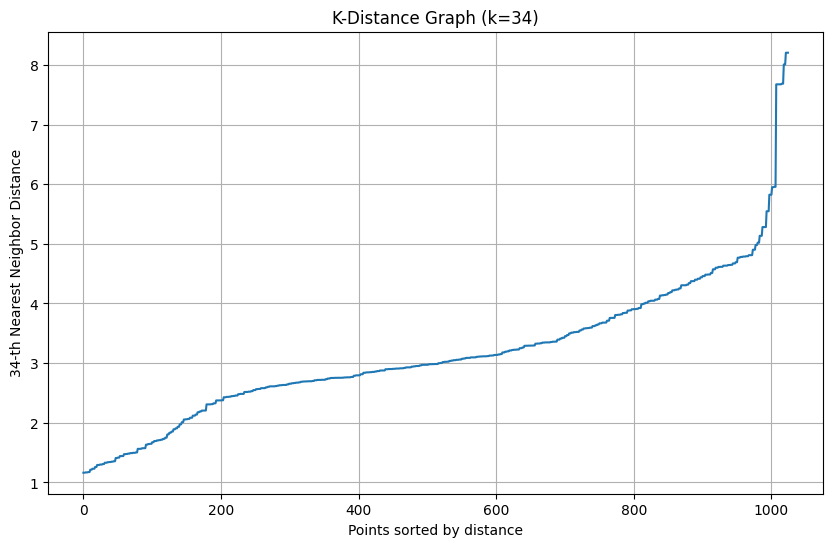

In [38]:
from sklearn.neighbors import NearestNeighbors

# Calculate the average distance of the k nearest neighbors for each point
# k menggunakan min_samples yang ideal
k = min_samples_ideal
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_final_scaled)
distances, indices = nbrs.kneighbors(X_final_scaled)

# Sortir jarak
distances = np.sort(distances[:, k-1], axis=0)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.title(f'K-Distance Graph (k={k})')
plt.grid(True)
plt.show()

cluster_dbscan
-1      24
 0    1001
Name: count, dtype: int64


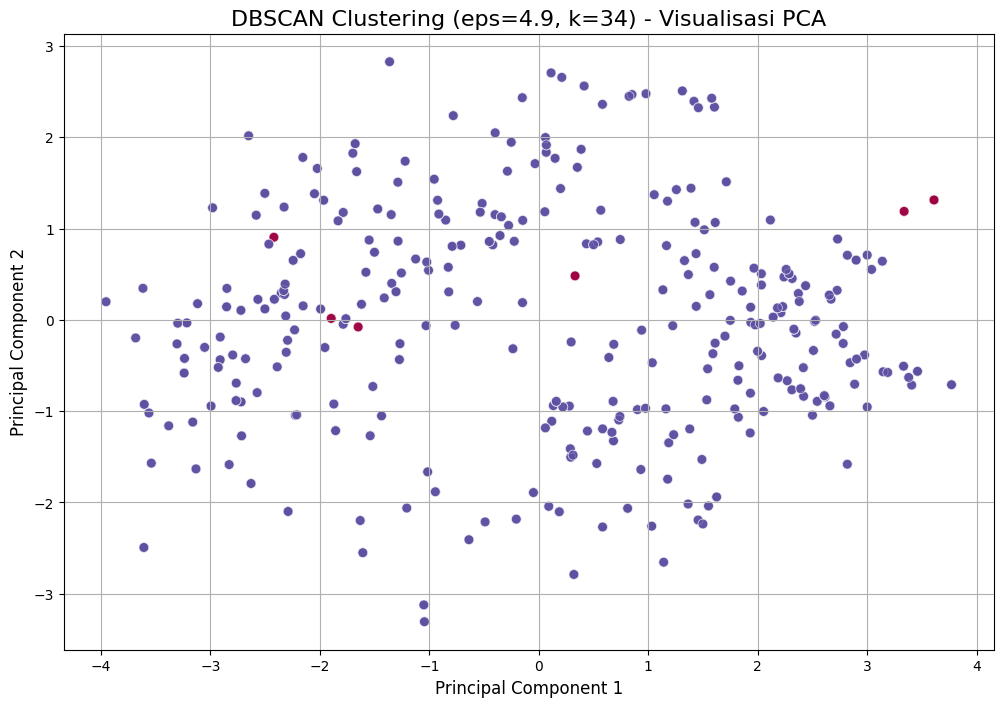

Silhouette Score (DBSCAN): 0.3862
Davies-Bouldin Index (DBSCAN): 1.5262


In [39]:
# EPS
eps_ideal = 4.9
k_ideal = min_samples_ideal

# Modelling
dbscan_model = DBSCAN(eps=eps_ideal, min_samples=k_ideal)
dbscan_labels = dbscan_model.fit_predict(X_final_scaled)

# Analisis Hasil
df['cluster_dbscan'] = dbscan_labels
# Cek ukuran tiap cluster
print(df['cluster_dbscan'].value_counts().sort_index())

plt.figure(figsize=(12, 8))
# 'X_pca' diambil dari Visualisasi KMeans
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                c=dbscan_labels,
                cmap='Spectral',   # Outlier Spotting
                s=50,
                alpha=0.7)

plt.title(f'DBSCAN Clustering (eps={eps_ideal}, k={k_ideal}) - Visualisasi PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True)
plt.show()

# Silhouette and the other
silhouette_avg = silhouette_score(X_final_scaled, dbscan_labels)
davies_bouldin_avg = davies_bouldin_score(X_final_scaled, dbscan_labels)

print(f"Silhouette Score (DBSCAN): {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index (DBSCAN): {davies_bouldin_avg:.4f}")

In [40]:
# Adu S-Score dan DBIndex:
# KMeans's
silhouette_avg = silhouette_score(X_final_scaled, kmeans_labels)
davies_bouldin_avg = davies_bouldin_score(X_final_scaled, kmeans_labels)
print(f"Silhouette Score (KMeans): {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index (KMeans): {davies_bouldin_avg:.4f}")

# DBSCAN
silhouette_avg = silhouette_score(X_final_scaled, dbscan_labels)
davies_bouldin_avg = davies_bouldin_score(X_final_scaled, dbscan_labels)
print(f"Silhouette Score (DBSCAN): {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index (DBSCAN): {davies_bouldin_avg:.4f}")

Silhouette Score (KMeans): 0.1836
Davies-Bouldin Index (KMeans): 2.0781
Silhouette Score (DBSCAN): 0.3862
Davies-Bouldin Index (DBSCAN): 1.5262


# Apprximate Nearest Neighbours
Featuring: Annoy

In [44]:
# Dimensi Data
dim = X_final_scaled.shape[1]
# Index Annoy
ann = AnnoyIndex(dim, 'euclidean')

# Masukkan data dan bangun index annoy
for i in range(X_final_scaled.shape[0]):
    ann.add_item(i, X_final_scaled[i])
# Compile
n_trees = 30
ann.build(n_trees)

# Titik Query untuk di-intip
query_idx = 42  # mengintip 42
k = 10          # 10 Terdekat

print(f"\n--- Mencari {k} tetangga terdekat dari titik index ke-{query_idx} ---")
neighbor_indices, neighbor_distances = ann.get_nns_by_item(
    query_idx,
    k,
    include_distances=True
)

print(f"\nIndeks Tetangga Terdekat: {neighbor_indices}")
print(f"Jarak ke Tetangga: {neighbor_distances}")

print("\n--- DATA ASLI ---")
print(df.iloc[neighbor_indices])


--- Mencari 10 tetangga terdekat dari titik index ke-42 ---

Indeks Tetangga Terdekat: [42, 670, 759, 924, 37, 659, 879, 234, 761, 956]
Jarak ke Tetangga: [0.0, 0.0, 0.0, 0.0, 1.176055669784546, 1.176055669784546, 1.176055669784546, 1.7501041889190674, 1.7501041889190674, 1.7501041889190674]

--- DATA ASLI ---
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
42    61    0   0       130   330    0        0      169      0      0.0   
670   61    0   0       130   330    0        0      169      0      0.0   
759   61    0   0       130   330    0        0      169      0      0.0   
924   61    0   0       130   330    0        0      169      0      0.0   
37    59    1   0       138   271    0        0      182      0      0.0   
659   59    1   0       138   271    0        0      182      0      0.0   
879   59    1   0       138   271    0        0      182      0      0.0   
234   49    0   0       130   269    0        1      163      0      0.0   
761

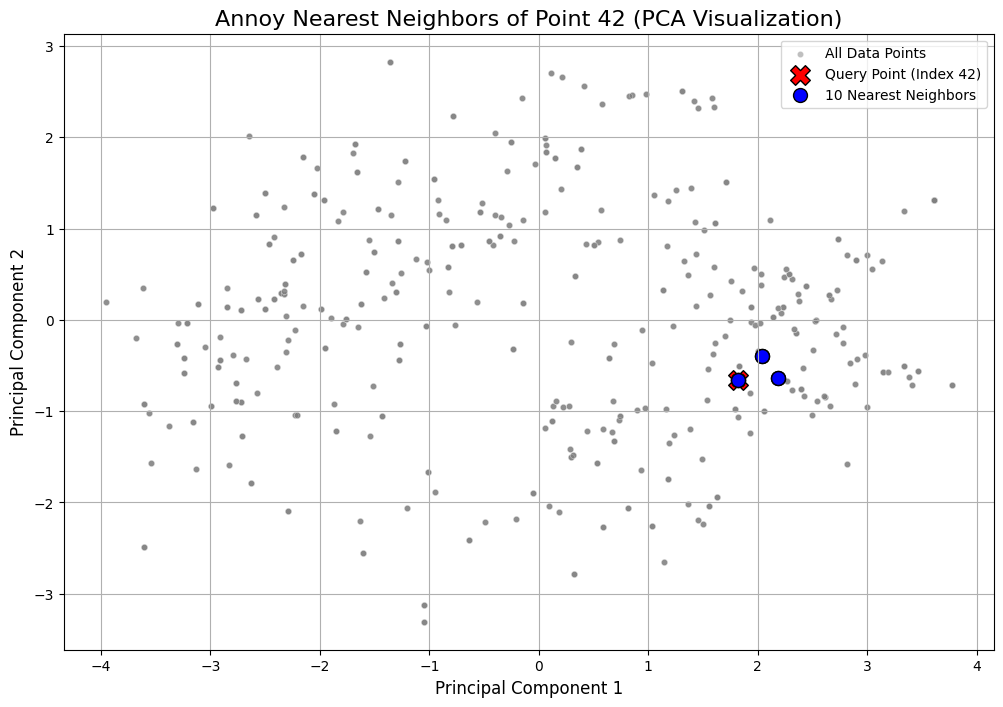

In [46]:
plt.figure(figsize=(12, 8))

# Plot all data
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], color='gray', s=20, alpha=0.5, label='All Data Points')
plt.scatter(X_pca[query_idx, 0], X_pca[query_idx, 1], color='red', s=200, marker='X', label=f'Query Point (Index {query_idx})', edgecolor='black')
neighbor_pca = X_pca[neighbor_indices]
plt.scatter(neighbor_pca[:, 0], neighbor_pca[:, 1], color='blue', s=100, marker='o', label=f'{k} Nearest Neighbors', edgecolor='black')

plt.title(f'Annoy Nearest Neighbors of Point {query_idx} (PCA Visualization)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Tulis kesimpulan singkat:
1. Perbedaan hasil KMeans dan DBSCAN, mana yang lebih baik diantara kedua model ini
dan jelaskan jawaban anda
2. Nilai metrik terbaik (Silhouette, DBI).
3. Hasil query Annoy: apakah tetangga yang ditemukan termasuk dalam cluster yang
sama? Jelaskan jawaban anda.
- - -

## Kesimpulan singkat
1. Pada hasil KMeans dan DBSCAN, terbukti bahwa DBSCAN memiliki hasil yang lebih baik dengan metode KMeans memiliki Silhouette Score sebesar 0.1836 dan Davies-Bouldin Index score sebesar 2.0781. Sedangkan untuk hasil DBSCAN mendapatkan skor Silhouette Score sebesar 0.3862 dan Davies-Bouldin Index sebesar 1.5262. Nilai Silhouette yang mendekati satu menandakan model bekerja dengan baik, sedangkan pada Davies-Bouldin Index, jika nilainya mendekati 0, maka hasilnya akan semakin bagus. Pada dataset ini, karena adanya fitur-fitur baru yang ditambahkan memungkinkan adanya perbedaan signifikan pada kedua model tersebut seperti fitur gabungan seperti “CholAge” atau “Risk_Score” yang secara esensi merubah data itu sendiri dengan merentangkan data di ruang multi-dimensi. Algoritma DBSCAN juga dapat menemukan outlier yang akan dimasukkan kedalam cluster -1, sehingga anomali data dapat di-exclude dari cluster yang bersangkutan sedangkan Kmeans tidak bisa, yang menyebabkan pusat centroid bergerak menjauh dari pusat seharusnya.

2. Nilai metrik terbaik yang didapatkan setelah beberapa modifikasi adalah sebagai berikut:


In [62]:
# Experiment Zone for Higher EPS
eps_ideal = 5.3
k_ideal = min_samples_ideal

# Modelling
dbscan_model = DBSCAN(eps=eps_ideal, min_samples=k_ideal)
dbscan_labels = dbscan_model.fit_predict(X_final_scaled)

# Analisis Hasil
df['cluster_dbscan'] = dbscan_labels
# Cek ukuran tiap cluster
print(df['cluster_dbscan'].value_counts().sort_index())

# Silhouette and the other
silhouette_avg = silhouette_score(X_final_scaled, dbscan_labels)
davies_bouldin_avg = davies_bouldin_score(X_final_scaled, dbscan_labels)

print(f"Silhouette Score (DBSCAN): {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index (DBSCAN): {davies_bouldin_avg:.4f}")

cluster_dbscan
-1      18
 0    1007
Name: count, dtype: int64
Silhouette Score (DBSCAN): 0.4144
Davies-Bouldin Index (DBSCAN): 0.8625


In [68]:
# Experiment Zone - KMeans
kmeans_model = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
kmeans_labels = kmeans_model.fit_predict(X_final_scaled)
silhouette_avg = silhouette_score(X_final_scaled, kmeans_labels)
davies_bouldin_avg = davies_bouldin_score(X_final_scaled, kmeans_labels)

print(f"Silhouette Score (KMeans): {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index (KMeans): {davies_bouldin_avg:.4f}")

Silhouette Score (KMeans): 0.2006
Davies-Bouldin Index (KMeans): 1.8527


Pada hasil eksperimen tersebut dilaporkan pada metode Kmeans, nilai silhouette terbaik ada pada Kmeans (k = 3), sedangkan nilai Davies-Bouldin Index terbaik pada metode Kmeans ada pada Kmeans (k = 4). Sedangkan pada DBSCAN, jumlah eps terbaik ada pada DBSCAN (eps = 5.4) dengan nilai silhouette 0.4144 dan nilai DBI sebanyak 1.8160

3. Hasil Query Annoy untuk mengecek apakah semua cluster yang sama

In [77]:
# Experiment Zone - Annoy
dim = X_final_scaled.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

for i in range(X_final_scaled.shape[0]):
    ann.add_item(i, X_final_scaled[i])
n_trees = 30
ann.build(n_trees)

# Titik Query untuk di-intip
query_idx = 67  # mengintip
k = 50          # X Terdekat

print(f"\n--- Mencari {k} tetangga terdekat dari titik index ke-{query_idx} ---")
neighbor_indices, neighbor_distances = ann.get_nns_by_item(
    query_idx,
    k,
    include_distances=True
)

print(f"\nIndeks Tetangga Terdekat: {neighbor_indices}")
print(f"Jarak ke Tetangga: {neighbor_distances}")

print("\n--- DATA ASLI ---")
# Include KMeans labels in the output
df_neighbors = df.iloc[neighbor_indices].copy()
df_neighbors['kmeans_cluster'] = kmeans_labels[neighbor_indices]
print(df_neighbors)

print(f"\nKMeans Cluster of Query Point {query_idx}: {kmeans_labels[query_idx]}")


--- Mencari 50 tetangga terdekat dari titik index ke-67 ---

Indeks Tetangga Terdekat: [67, 607, 834, 998, 353, 703, 887, 166, 564, 845, 30, 93, 121, 780, 327, 412, 760, 806, 135, 264, 612, 819, 129, 873, 980, 28, 338, 405, 717, 274, 375, 398, 757, 594, 608, 1000, 356, 587, 682, 114, 206, 308, 903, 14, 686, 734, 893, 46, 132, 770]
Jarak ke Tetangga: [0.0, 0.0, 0.0, 0.0, 1.161655068397522, 1.161655068397522, 1.161655068397522, 2.8737294673919678, 2.8737294673919678, 2.8737294673919678, 2.9310827255249023, 2.9310827255249023, 2.9310827255249023, 2.9310827255249023, 2.9423441886901855, 2.9423441886901855, 2.9423441886901855, 2.9423441886901855, 3.3834898471832275, 3.3834898471832275, 3.3834898471832275, 3.3834898471832275, 3.401946783065796, 3.401946783065796, 3.401946783065796, 3.6829864978790283, 3.6829864978790283, 3.6829864978790283, 3.6829864978790283, 3.7834904193878174, 3.7834904193878174, 3.7834904193878174, 3.7834904193878174, 3.807114362716675, 3.807114362716675, 3.807114362716

3. Untuk hasil dari Annoy, menurut tabel output berikut, mengambil dari hasil dari DBSCAN yang berjalan baik, semua tetangga dari data hasil percobaan dengan nilai yang berbeda seperti 67, 69, dan 131, semua tetangganya adalah dari cluster yang sama, meskipun nilai tetangga ditambah menjadi 50. Hal ini disebabkan karena tetangga yang dicari dari ANNOY berjarak kurang dari jumlah eps terbaik yang di set (eps = 5.4) pada DBSCAN. Hal yang juga memungkinkan bahwa cluster 0 pada hasil DBSCAN juga berarti bahwa semua data dalam satu cluster mungkin saja saling menyambung karena meskipun 50 tetangganya di scan.

    Sementara untuk K-Means, ada beberapa nilai yang berada pada cluster yang berbeda, namun tetangganya yang lain lebih cendetung mengarah ke cluster yang sama. Ini kemungkinan disebabkan oleh banyaknya cluster atau karena ketidakmampuan metode Kmeans dalam menangani outlier, namun Annoy juga berhasil dalam menemukan titik data Euclidean yang dekat dengan fitur yang diambil dan lebih cenderung ke cluster K-Means yang sama dikarenakan data KMeans juga mengelompokkan titik-titik berdasarkan jarak Euclidean ke centroid cluster.